In [166]:
%load_ext autoreload
%autoreload 2

import cvxpy as cp

import numpy as np
from scipy.optimize import minimize
import ipi_project as ipi
import phantoms
from skimage.filters import gaussian

import matplotlib.pyplot as plt

import astra

from topolar import topolar

import scipy.sparse
from matrixT import create_T
from matrixT import create_Dx
from matrixT import create_Blur

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


18.10193359837562


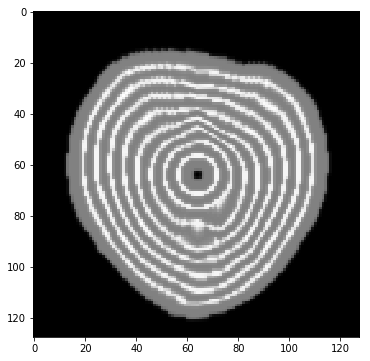

18.10193359837562


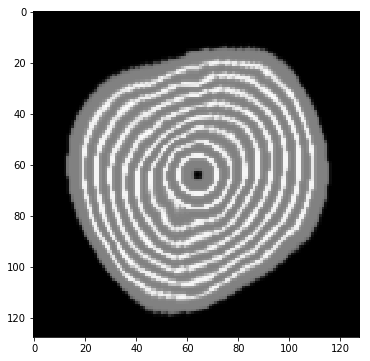

18.10193359837562


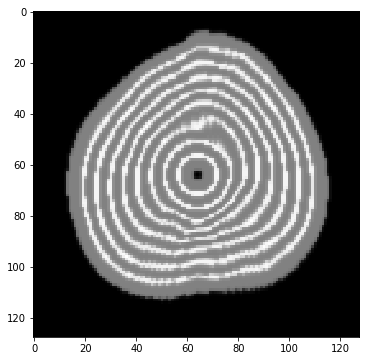

18.10193359837562


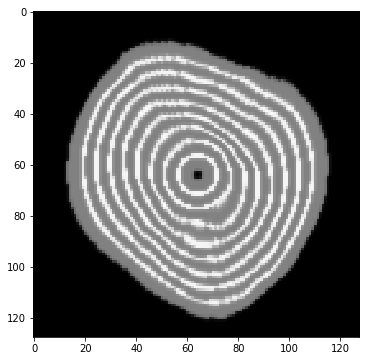

18.10193359837562


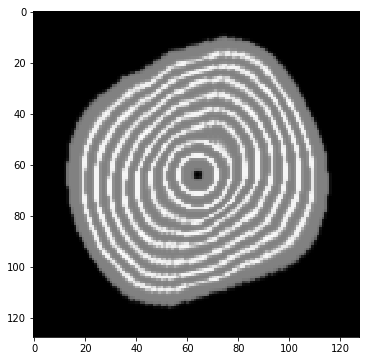

In [173]:
circle = phantoms.circle(128,12, wall_thickness=7)
#circle = np.pad(circle, pad_width=10, mode='constant', constant_values=0)
circle = gaussian(circle, sigma=0.5, preserve_range=True)
for _ in range(5):
    wobbly, src, inv_src = phantoms.wobbly_transform(circle, amplitude=5)
    #wobbly = gaussian(wobbly, sigma=1.0, preserve_range=True)


    plt.figure(figsize=(6,6))
    plt.imshow(wobbly, cmap='gray')
    plt.show()

In [3]:
A = ipi.astra_proj_matrix(128, proj_size=circle.shape[0], proj_angles=np.linspace(0, 2.0*np.pi, 5))

In [18]:
A.shape

(320, 4096)

In [5]:
print("A ", A.shape)
type(A)
print("A flat", np.ravel(A).shape)
print("Circle flat", circle.ravel().shape)

A  (320, 4096)
A flat (1,)
Circle flat (4096,)


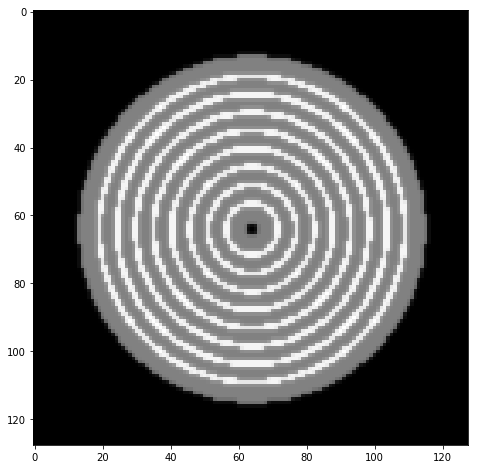

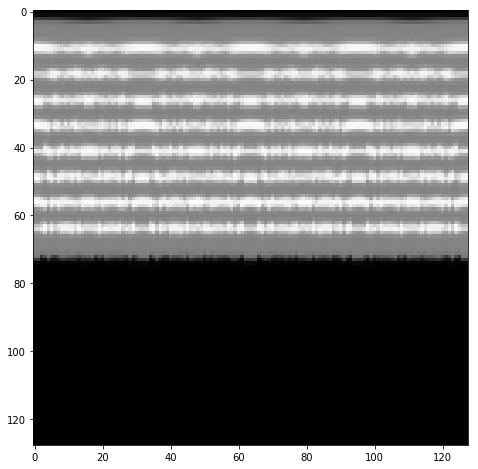

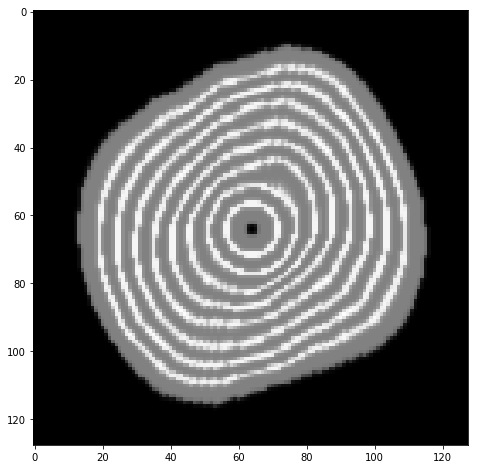

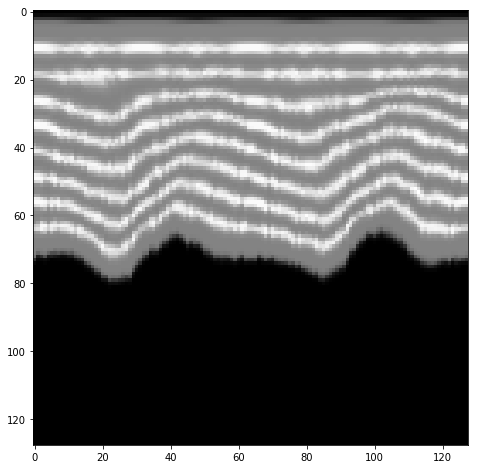

In [174]:
proj_angles = np.linspace(0, 2.0*np.pi, 180)
W, proj_id = ipi.create_OpTomo(circle.shape[0], proj_size=150, proj_angles=proj_angles)

matrix_id = astra.projector.matrix(proj_id)

A = astra.matrix.get(matrix_id)

def polar_and_sinogram(phantom, proj_id, plot=False):

    sino = astra.creators.create_sino(phantom, proj_id)[1]

    polar = topolar(phantom)[0]

    if plot:
        plt.figure(figsize=(8,8))
        plt.imshow(phantom, cmap='gray')
        plt.show()
        
        plt.figure(figsize=(8,8))
        plt.imshow(polar, cmap='gray')
        plt.show()
        #plt.imshow(sino, cmap='gray')
        #plt.show()
        
    return polar, sino
    
    
polar, sino = polar_and_sinogram(circle, proj_id, plot=True)
_ = polar_and_sinogram(wobbly, proj_id, plot=True)

In [175]:
def make_forward_diff(size):
    Dx = np.diag([1.0]*size) - np.diag([1.0]*(size -1), k=1)
    Dx[-1,0] = -1.0
    return Dx
                                     

In [176]:
def polar_line_regularization(image, Dx):
    polar_img = topolar(image)[0]
    diff_x =  polar_img @ Dx
    plt.imshow(np.abs(diff_x), cmap='gray')
    plt.show()
    return diff_x

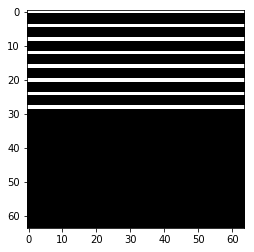

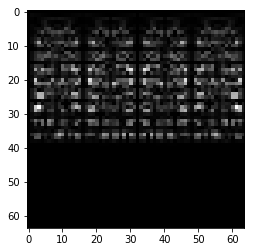

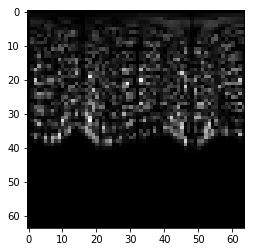

Perf Polar reg 0.0
Circ reg 6.166181647989153
Wobbly reg 6.374515801002487


In [7]:
Dx = make_forward_diff(circle.shape[0])

polar_perfect = np.zeros_like(circle)
polar_perfect[ [i for i in range(circle.shape[0]) if i % 4 == 0 and i < circle.shape[0] // 2] ] = 1.0

plt.imshow(polar_perfect, cmap='gray')
plt.show()
perfect_reg =  polar_perfect @ Dx

circ_reg = polar_line_regularization(circle, Dx)
wobbly_reg = polar_line_regularization(wobbly, Dx)

print("Perf Polar reg", np.linalg.norm(perfect_reg))
print("Circ reg", np.linalg.norm(circ_reg))
print("Wobbly reg", np.linalg.norm(wobbly_reg))

In [30]:
np.min(wobbly_reg)

-0.9843426487778295

In [31]:
np.max(wobbly_reg)

0.9791185179216253

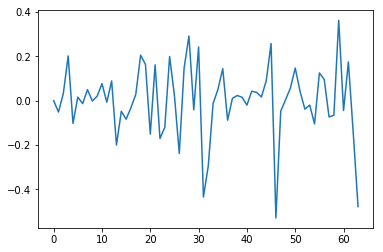

In [26]:
plt.plot(wobbly_reg[20])

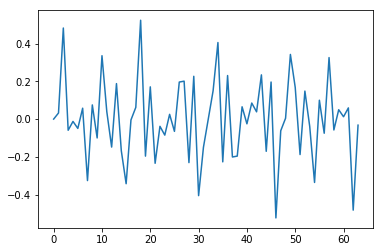

In [27]:
plt.plot(circ_reg[20])

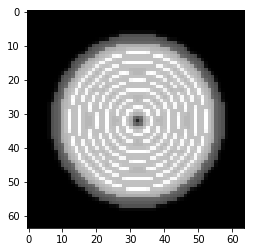

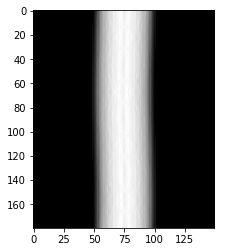

In [118]:
y = A @ circle.ravel()

circle_sino = y.reshape(180,150)

plt.imshow(circle, cmap='gray')
plt.show()

plt.imshow(circle_sino, cmap='gray')

## Unregularized least square

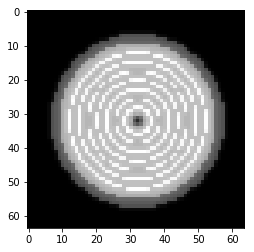

In [119]:
x_sol = scipy.sparse.linalg.lsqr(A, y)

plt.imshow(x_sol[0].reshape(64,64), cmap='gray')

In [13]:
Tmat= create_T(64)


In [90]:
Tmat.shape

(4096, 4096)

## Topolar and Dx test

In [14]:
Dx_sparse = create_Dx(64)

In [15]:
Tmat_sparse = scipy.sparse.csr_matrix(Tmat)

In [42]:
G = create_Blur(64, 0.6)

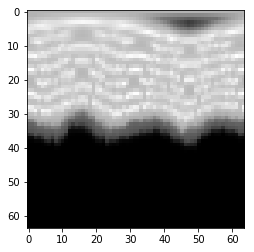

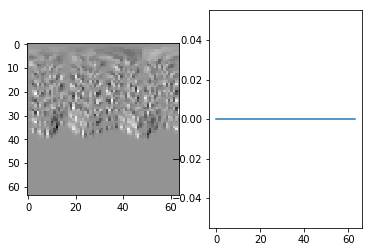

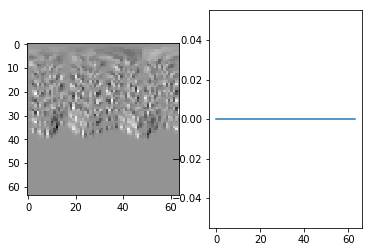

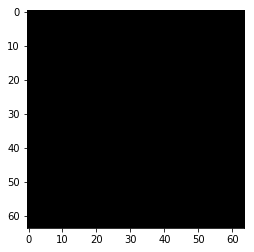

In [16]:
polar_wobbly = (Tmat_sparse @ wobbly.ravel())
plt.imshow(polar_wobbly.reshape(64,64), cmap='gray')
plt.show()

polar_wobbly_dx = Dx_sparse @ polar_wobbly
plt.subplot(121)
plt.imshow(polar_wobbly_dx.reshape(64,64), cmap='gray')
plt.subplot(122)
plt.plot((polar_wobbly_dx.reshape(64,64)[50]))
plt.show()

polar_wobbly2d = polar_wobbly.reshape(64,64)
polar_wobbly_dx_by_hand = polar_wobbly2d - np.roll(polar_wobbly2d, 1, axis=1)

plt.subplot(121)
plt.imshow(polar_wobbly_dx_by_hand, cmap='gray')
plt.subplot(122)
plt.plot(polar_wobbly_dx_by_hand[50])
plt.show()

plt.imshow(np.abs(polar_wobbly_dx.reshape(64,64) - polar_wobbly_dx_by_hand), cmap='gray')
plt.show()

Regularized


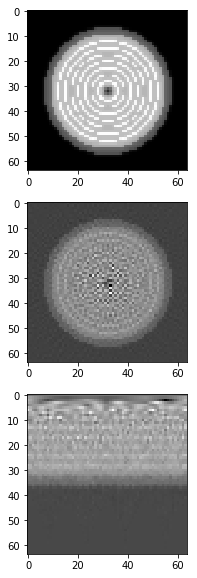

In [124]:
AT = scipy.sparse.vstack((A,  0.04 * Dx_sparse @ Tmat_sparse)) # @ create_Blur(64, 0.5)))

y_reg = np.zeros(AT.shape[0])

noise = np.random.randn(*y.shape)

y_reg[0:y.shape[0]] = y + 0.25*noise

x_sol_reg = scipy.sparse.linalg.lsqr(AT, y_reg)

print("Regularized")
plt.figure(figsize=(10,10))
plt.subplot(311)
plt.imshow(x_sol[0].reshape(64,64), cmap='gray')
plt.subplot(312)
plt.imshow(x_sol_reg[0].reshape(64,64), cmap='gray')
plt.subplot(313)
plt.imshow(topolar(x_sol_reg[0].reshape(64,64))[0], cmap='gray')
plt.show()

In [125]:
np.min(x_sol_reg[0])

-1.9027359594624096

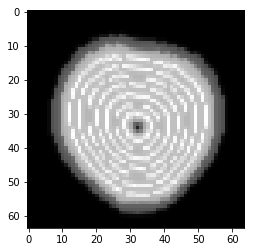

In [40]:
# No Regularization
plt.imshow(x_sol[0].reshape(64,64), cmap='gray')

In [99]:
y_reg = scipy.sparse.csr_matrix((AT.shape[0], 1))

In [100]:
y_reg[0:y.shape[0]] = y

/home/fgustafsson/venv/tf_14/lib/python3.5/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [32]:
x_sol_reg = scipy.sparse.linalg.lsqr(AT, y_reg)

NameError: name 'AT' is not defined

In [102]:
AT.shape

(31096, 4096)

In [103]:
y_reg.shape

(31096, 1)

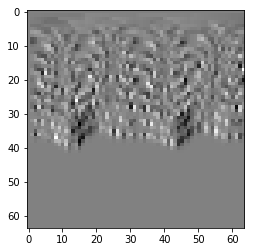

In [142]:
plt.imshow( (Tmat @ wobbly.ravel()).reshape(64,64) @ Dx, cmap='gray')

In [105]:
y.shape

(27000, 1)

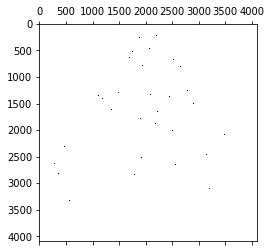

In [144]:
plt.spy(Tmat)

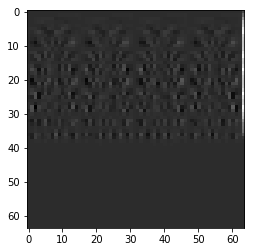

In [160]:
dtc = (Dx_sparse @ Tmat_sparse @ circle.ravel()).reshape(64,64)
plt.imshow(dtc, cmap='gray')

## Least squares with L1

In [40]:
G = create_Blur(64, 0.6)

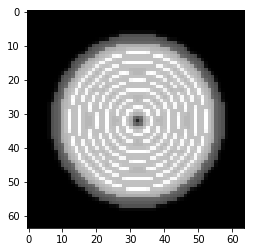

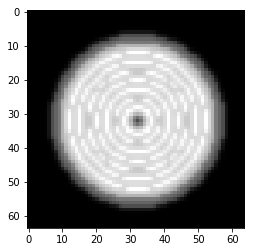

In [41]:
plt.imshow(circle, cmap='gray')
plt.show()

blurred_circle = (G @ circle.ravel()).reshape(64,64)
plt.imshow(blurred_circle, cmap='gray')

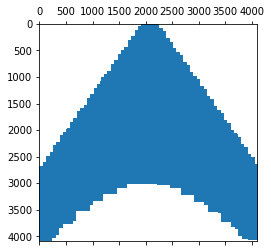

In [94]:
plt.spy(Tmat_sparse)

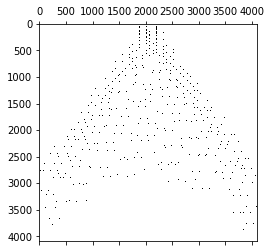

In [100]:
plt.spy(Dx_sparse @ Tmat_sparse @ create_Blur(64, 0.5))

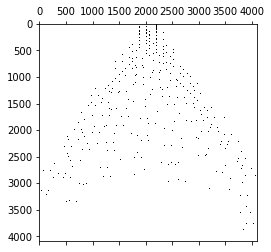

In [101]:
plt.spy(Tmat_sparse @ create_Blur(64, 0.5))

In [103]:
scipy.sparse.linalg.norm(Tmat_sparse)

38.45947640647606

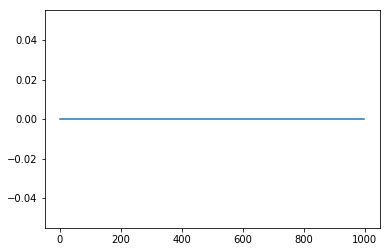

In [114]:
plt.plot(Tmat_sparse.toarray()[2000,2000:3000])